#### Imports

In [1]:
from neo4j import GraphDatabase
import matplotlib.pyplot as plt

#### Connection

In [2]:
uri = "neo4j://localhost:7687"
username = "neo4j"
password = "12345678"

#### Exploration related to defining the batching time interval

##### I Query to compare arrival time of kits on Entrada

In [3]:
cypher_query_kit_arival_entrada = """
MATCH (e1:Event)-[:CORR]->(k1:Kit)
WHERE e1.activity = "Entrada Material Sucio"
WITH e1, date(e1.timestamp) AS event_date
ORDER BY event_date, e1.timestamp
WITH event_date, collect(e1.timestamp) AS event_timestamps
WITH event_date, apoc.coll.pairsMin(event_timestamps) AS pairs
UNWIND pairs AS pair
WITH pair[0] AS timestamp1String, pair[1] AS timestamp2String
WITH datetime(timestamp1String) AS timestamp1, datetime(timestamp2String) AS timestamp2
RETURN timestamp1, timestamp2, (timestamp2.epochMillis - timestamp1.epochMillis) / (1000 * 60) AS time_difference_minutes
"""


def execute_query_kit_arival_entrada(uri, username, password, cypher_query_kit_arival_entrada):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_query_kit_arival_entrada)
        data = result.data()
        return data
    
results_kit_arival_entrada = execute_query_kit_arival_entrada(uri, username, password, cypher_query_kit_arival_entrada)
# uncomment to see the result
#print(results_kit_arival_entrada) # uncomment to see the result

##### II Query to get statistics of arrival time of kits on Entrada

In [9]:
cypher_query_stats_kit_arival_entrada = """
MATCH (e1:Event)-[:CORR]->(k1:Kit)
WHERE e1.activity = "Entrada Material Sucio"
WITH e1, date(e1.timestamp) AS event_date
ORDER BY event_date, e1.timestamp
WITH event_date, collect(e1.timestamp) AS event_timestamps
WITH event_date, apoc.coll.pairsMin(event_timestamps) AS pairs
UNWIND pairs AS pair
WITH pair[0] AS timestamp1String, pair[1] AS timestamp2String
WITH datetime(timestamp1String) AS timestamp1, datetime(timestamp2String) AS timestamp2
RETURN min((timestamp2.epochMillis - timestamp1.epochMillis) / (1000 * 60)) AS min_time_difference_minutes,
       max((timestamp2.epochMillis - timestamp1.epochMillis) / (1000 * 60)) AS max_time_difference_minutes,
       avg((timestamp2.epochMillis - timestamp1.epochMillis) / (1000 * 60)) AS avg_time_difference_minutes
"""

def execute_query_stats_kit_arival_entrada(uri, username, password, cypher_query_stats_kit_arival_entrada):
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run(cypher_query_stats_kit_arival_entrada)
        return result.data()
    
stats_results_kit_arival_entrada = execute_query_stats_kit_arival_entrada(uri, username, password, cypher_query_stats_kit_arival_entrada)
print(stats_results_kit_arival_entrada)

[{'min_time_difference_minutes': 0, 'max_time_difference_minutes': 350, 'avg_time_difference_minutes': 5.182642968691923}]


##### Kits arrival time distribution visualisation

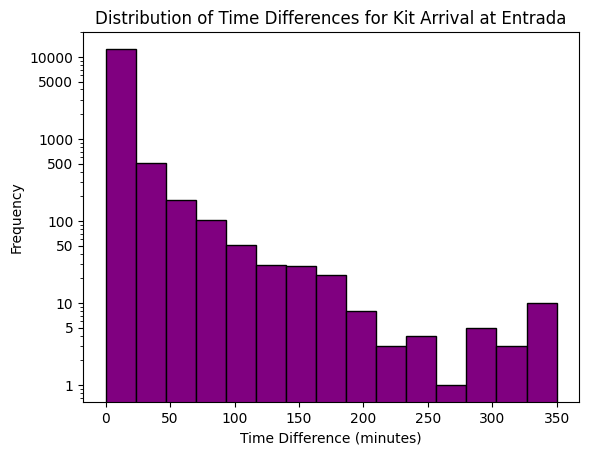

In [7]:
time_difference_minutes = [record["time_difference_minutes"] for record in results_kit_arival_entrada]

plt.hist(time_difference_minutes, bins=15, color='purple', edgecolor='black')

plt.xlabel('Time Difference (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Differences for Kit Arrival at Entrada')

plt.yscale('log')

yticks = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
plt.yticks(yticks, [str(y) for y in yticks])

plt.show()